# **Agglomerative Hierarchical Clustering Regression**

## **1. Importing Libararies**

In [249]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, AdaBoostRegressor
from sklearn.cluster import AgglomerativeClustering
from sklearn.linear_model import LinearRegression
import scipy.cluster.hierarchy as shc
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## **2. Reading Data and Header View**

In [250]:
df = pd.read_csv('air_conditioner_prices_dataset.csv')
df.head()

,Brand,Capacity (BTUs),EER/SEER,Type,Features,Location,Age (years),Price ($)
0,Brand A,18000,14.6,Portable,Quiet,India,3,239
1,Brand C,8000,12.3,Portable,WiFi,USA,4,348
2,Brand B,15000,12.4,Window,WiFi,Europe,4,325
3,Brand C,18000,15.6,Split,Standard,Australia,4,480
4,Brand C,12000,17.5,Portable,"Inverter Technology, WiFi",Australia,2,881


## **3. Shape of Data**

In [251]:
df.shape

(200, 8)

## **4. Info about Data**

In [252]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Brand            200 non-null    object 
 1   Capacity (BTUs)  200 non-null    int64  
 2   EER/SEER         200 non-null    float64
 3   Type             200 non-null    object 
 4   Features         200 non-null    object 
 5   Location         200 non-null    object 
 6   Age (years)      200 non-null    int64  
 7   Price ($)        200 non-null    int64  
dtypes: float64(1), int64(3), object(4)
memory usage: 12.6+ KB


## **5. Null Values Distribution**

In [253]:
df.isnull().sum()

Brand              0
Capacity (BTUs)    0
EER/SEER           0
Type               0
Features           0
Location           0
Age (years)        0
Price ($)          0
dtype: int64

## **6. Data Types of Features**

In [254]:
df.dtypes

Brand               object
Capacity (BTUs)      int64
EER/SEER           float64
Type                object
Features            object
Location            object
Age (years)          int64
Price ($)            int64
dtype: object

## **7. Description of Data**

In [255]:
df.describe(include='all')

,Brand,Capacity (BTUs),EER/SEER,Type,Features,Location,Age (years),Price ($)
count,200,200.000000,200.000000,200,200,200,200.000000,200.000000
unique,3,NaN,NaN,3,30,4,NaN,NaN
top,Brand A,NaN,NaN,Portable,WiFi,India,NaN,NaN
freq,71,NaN,NaN,73,27,58,NaN,NaN
mean,NaN,12305.000000,16.112500,NaN,NaN,NaN,2.360000,604.850000
std,NaN,3507.633456,2.386687,NaN,NaN,NaN,1.129949,222.109931
min,NaN,8000.000000,12.000000,NaN,NaN,NaN,1.000000,203.000000
25%,NaN,10000.000000,13.850000,NaN,NaN,NaN,1.000000,435.500000
50%,NaN,12000.000000,16.400000,NaN,NaN,NaN,2.000000,592.500000
75%,NaN,15000.000000,18.050000,NaN,NaN,NaN,3.000000,802.500000


## **8. Train Test Split**

In [256]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['Price ($)']),
                                                    df['Price ($)'],
                                                    test_size=0.2,
                                                    random_state=42)

## **9. Separating Numerical and Categorical Columns**

In [257]:
numerical_columns = [1, 2, 6]
nominal_columns = [0, 3, 4, 5]

## **10. Handling Outliers**

In [258]:
numerical_columns_outliers = ['Capacity (BTUs)', 'EER/SEER', 'Age (years)']
def cap_outliers_iqr(df, numerical_columns_outliers):
    for column in numerical_columns_outliers:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        df[column] = df[column].apply(lambda x: lower_bound if x < lower_bound else upper_bound if x > upper_bound else x)
    
    return df

df = cap_outliers_iqr(df, numerical_columns_outliers)

## **11. Creating Pipelines**

In [259]:
handle_numerical = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scale', MinMaxScaler())
])

In [260]:
handle_nominal = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encode', OneHotEncoder(handle_unknown='ignore'))
])

## **12. Combining it in Transformer**

In [261]:
preprocessing = ColumnTransformer(transformers=[
    ('numerical', handle_numerical, numerical_columns),
    ('nominal', handle_nominal, nominal_columns)
])

## **13. Fitting Preprocessing to Train and Test Data**

In [262]:
X_train_preprocessed = preprocessing.fit_transform(X_train)
X_test_preprocessed = preprocessing.transform(X_test)

In [263]:
X_train_preprocessed_dense = X_train_preprocessed.toarray()
X_test_preprocessed_dense = X_test_preprocessed.toarray()

## **14. Dendogram**

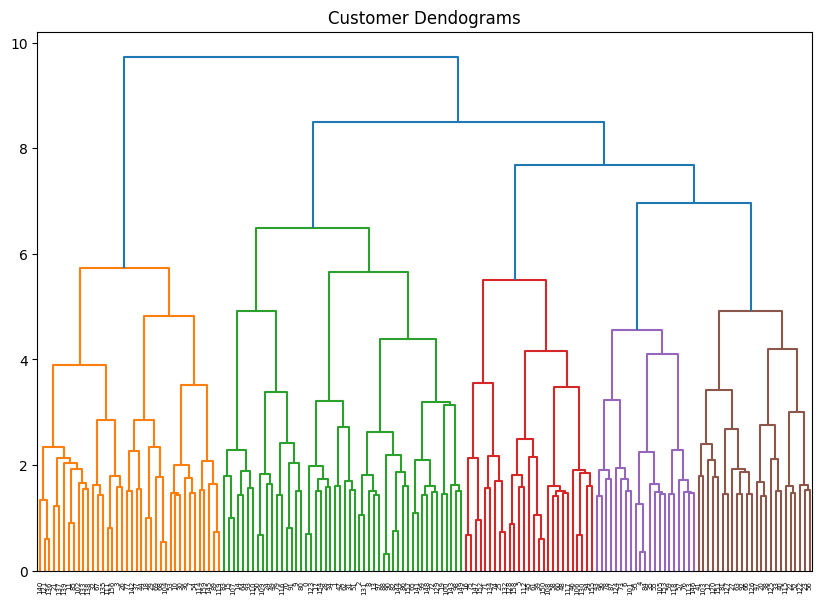

In [264]:
plt.figure(figsize=(10, 7))
plt.title("Customer Dendograms")
dend = shc.dendrogram(shc.linkage(X_train_preprocessed_dense, method='ward'))
plt.show()

## **15. Agglomerative Clustering**

In [265]:
clustering = AgglomerativeClustering(n_clusters=6)
X_train_clusters = clustering.fit_predict(X_train_preprocessed_dense)
X_test_clusters = clustering.fit_predict(X_test_preprocessed_dense)

In [266]:
X_train['Cluster'] = X_train_clusters
X_test['Cluster'] = X_test_clusters

In [267]:
preprocessing_with_clusters = ColumnTransformer(transformers=[
    ('numerical', handle_numerical, numerical_columns),
    ('nominal', handle_nominal, nominal_columns),
    ('clusters', 'passthrough', ['Cluster'])
])

In [268]:
X_train_preprocessed_with_clusters = preprocessing_with_clusters.fit_transform(X_train)
X_test_preprocessed_with_clusters = preprocessing_with_clusters.transform(X_test)

## **16. Applying Model and its Evaluation**

In [269]:
model = AdaBoostRegressor()

In [270]:
model.fit(X_train_preprocessed_with_clusters, y_train)

AdaBoostRegressor()

In [271]:
y_pred = model.predict(X_test_preprocessed_with_clusters)

In [272]:
r2 = r2_score(y_test, y_pred)
print(r2)

-0.12937010733637244
